# Table of Contents
- [Introduction](#introduction)
- [Dataset Description and Preprocessing](#dataset)
- [Clustering with K-Means](#dataset)
- [Classification with Naive-Bayes](#classification)
<br/>

# 1 Introduction <a name="introduction"></a>

In this assignment, we demonstrate the usage of machine learning for clustering and classification of text data.

In the first part we make use of the K-means algorithm in order to cluster user reviews on certain Amazon products.
This process is useful when the reviews are unlabeled and we wish to create different categories automatically based on the content of the reviews.
The TFIDF algorithm is used to convert the text data into feature vectors used by the algorithm. The experiments show that the clustering algorithm was able to discover the most fundamental categories.

The second part assumes that the reviews are labeled. The requirement is to automate the classification process, in order to assign new reviews to their corresponding category.
For this purpose we train an Naive-Bayes classifier and examine the performance on the test dataset.
We cover aspects such as the performance metrics (accuracy, precision, recall, etc.), training dataset size tuning and running time of the algorithm, and
conclude that the algorithm is able to produce decent results.

The code used in this notebook can also run as a microservice with an integrated UI, so that the users can experiment and use it as an actual tool.
More on this on the readme.md file.

<br/>

# 2 Dataset Description and Preprocessing <a name="dataset"><a/>

## 2.1 The dataset
The dataset is composed of various user reviews on products of the following categories:

* Books
* Clothing, shoes and jewelry
* Movies and TV
* Musical Instruments
* Software

Some samples taken from the movies dataset:

In [28]:
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

from util import import_data
import_data('datasets/movies_5000.json', size=100, file_type='json', field='reviewText').sample(4)

input
24  Of course it's impossible to separate Henry Wi...
41                       Great product, fast shipping
32  This TV movie brought back fond memories of th...
15  Well done video with important information tha...

The full dataset can be found here: http://jmcauley.ucsd.edu/data/amazon/

For our experiments we have sampled 5000 items from each category and created the corresponding json data file (for example, music_5000.json).
We also mixed samples from different categories in the files
samples_500_per_class.csv and samples_200_per_class.csv

In [30]:
%load_ext autoreload
%autoreload 2

from util import import_data
import random

random.seed(2)

size_per_class = 1000
data = import_data('datasets/clothing_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index()
data = data.append(import_data('datasets/books_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.append(import_data('datasets/movies_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.append(import_data('datasets/software_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.append(import_data('datasets/music_5000.json', size=5000, file_type='json', field='reviewText').sample(size_per_class).reset_index())
data = data.reset_index()
print("loaded data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loaded data


<br/>


## 2.2 Feature extraction
In order to represent the data in numeric form and in a meaningful way, the TFIDF algorithm is used.


### 2.2.1 Term Frequency – Inverse Document Frequency (TFIDF)
The TFIDF algorithm is used to transform a document into a numeric vector. Each unique word that appears in the
collection of documents (corpus), corresponds to a dimension of the vector. The algorithm combines two quantities:

<br/>

**Term Frequency**

The number of times a word $i$ appears in the document $d$ divided by the total number of words in that document.

<br/>

$TF(i,d) = \frac{f_{i,d}}{\sum_{i'\epsilon d} {f_{i',d}}}$


<br/>

**Inverse Document Frequency**

Common words that appear in most documents, may not provide useful information. In our use case, the words “good”,
“great” and “like” appear frequently in all kinds of user reviews, therefore do not add any value to the clustering process.
 Therefore the IDF score of a term is calculated, based on the number of documents containing this term versus the total
 number of documents:

 <br/>

$IDF(i,d) = \log\frac{|D|}{|\left \{ d\epsilon D: i\epsilon d \right \}|}$

<br/>

,where $|D|$ is the total count of documents, and $|\left \{ d\epsilon D: i\epsilon d \right \}|$ the count of documents containing the term i.
The TFIDF score is calculated by multiplying the above quantities:

<br/>

$ TFIDF(i,d) = TF(i,d) \cdot IDF(i,d)$

<br/>

**Example**

Consider the following documents:

* d0: “Good quality hat.“
* d1: “Fits great, looks good! “
* d2: “Good hat.“

The TDIDF matrix is calculated as:

In [14]:
import pandas as pd
from util.preprocess import TextPreprocessor

example = pd.Series(['Good quality hat.', 'Fits great, looks good!', 'Good hat.'])
tfidf_vector, tfidf_matrix, dense_tfidf_matrix = TextPreprocessor().generate_tfidf(example)
dense_tfidf_matrix

fit      good     great       hat      look   quality
0  0.000000  0.425441  0.000000  0.547832  0.000000  0.720333
1  0.546454  0.322745  0.546454  0.000000  0.546454  0.000000
2  0.000000  0.613356  0.000000  0.789807  0.000000  0.000000

### 2.2.2 Puncutation and stop words removal
In order to reduce the dataset size and noise, we remove punctuations and common words like “this”, “and”, “a”, etc…

Spacy.io is a fully featured library which can be used to perform such tasks.

### 2.2.3 Stemming/Lemmatization
Words inside a document need to be transformed to their root form in order for the TFIDF to perform. For example the words “driving” and “driver “ should point to the same term “drive”. Stemming is the process of performing such conversion.

Lemmatization is similar to stemming, while also taking into account meaning and the context in which the term is used. For example the words “people” and “person”, should point to the same lemma.

<br/>

## 2.3 Implementation

For preprocessing of the data we created a wrapper class that uses scikit-learn and spacy.
The class provides a method that takes the raw text data as input, performs lemmatization and stop words removal
and outputs the tfidf transformation.

In [16]:
from util.preprocess import TextPreprocessor



# 3 Clustering with Kmeans <a name="clustering"></a>

In this chapter we describe the Kmeans algorithm that was used for clustering the documents and discuss the results.

## 3.1. The Kmeans algorithm
Kmeans is an unsupervised machine learning algorithm for clustering data into a predefined number (K) of distinct groups (clusters). Each data point can belong only to a single cluster. The data is clustered in such a way that the sum of squared distances between a cluster’s centroid and all the points belonging to the cluster is minimized. 
The I/O of the algorithm is listed below:

Input: 
* Number of clusters
* Dataset

Output:
* Cluster centroids
* Clustered data points

The algorithm runs through an iterative process until a stop condition has occurred:

<br/>

<img src="kmeans.png" alt="kmeans" width="600"/>

## 3.2. Choosing optimal parameters

We will be using the silhouette method to determine the optimal number of clusters. The silhouette score is an indicator of how
well seperated the clusters are, and is defined by the following metric:

For each data point $i$, the mean distance from all points that belong to the same cluster $C_i$ is:

$a(i) = \frac{1}{|C_i|-1} \sum_{j \in C_i, j \neq i}{d(i,j)}$

We also define the mean distance of i from the all points that belong to the nearest cluster:

$b(i) = \min_{J \neq I}{\frac{1}{|C_J|}\sum_{j \in C_J}{d(i,j)}}$

The silhouette of point $i$ is defined as:

$s(i) = \frac{b(i)-a(i)}{\max\{a(i), b(i)\}}$

In [20]:
from services import *

size_per_class = 800
data = import_data('datasets/clothing_5000.json', size=5000, file_type='json',
                   field='reviewText').sample(size_per_class).reset_index()
data = data.append(import_data('datasets/books_5000.json', size=5000, file_type='json', field='reviewText').sample(
    size_per_class).reset_index())
data = data.append(
    import_data('datasets/movies_5000.json', size=5000, file_type='json', field='reviewText').sample(
        size_per_class).reset_index())
data = data.append(import_data('datasets/software_5000.json', size=5000, file_type='json', field='reviewText').sample(
    size_per_class).reset_index())
data = data.append(
    import_data('datasets/music_5000.json', size=5000, file_type='json', field='reviewText').sample(
        size_per_class).reset_index())
data = data.reset_index()
print("Loaded data")

tpr = TextPreprocessor(drop_common_words=False)
tfidf_vector, tfidf_matrix, dense_tfidf_matrix = tpr.generate_tfidf(data.input, debug=True)

Loaded data
Created tfidf_vectorizer
Created tfidf matrix
Created tfidf dense matrix


In [21]:
%load_ext autoreload
%autoreload 2
from models.clustering import TextClustering

tcl = TextClustering(data, tfidf_matrix, tfidf_vector, 12)
tcl.find_optimal_clusters(20, debug=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


Around the number 12 we can see that the curve slightly flattens.
Further increasing the number of clusters will not provide any benefit, since the clusters will become sparse and small in size.
Since the number of dimensions generated with TFIDF is very high compared to the number of samples,
the knee point of the curve is not so obvious.

## 3.3 Exploring and evaluating the clustered data

In [31]:
from IPython.display import display

n_clusters = 12
tcl.fit_kmeans(n_clusters)

for i in range(n_clusters):
    idx = tcl.clustered_data.pred == i
    print("Cluster {}".format(i))
    display(tcl.clustered_data.loc[idx, ['input', 'top_terms']][0:5])

c:\users\pmitseas\documents\mscai\machinelearning\assignment\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Cluster 0


input  \
1114                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              I have seen the movie many times and now know how much literally license the movie-makers can take!   
1135                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Jumped ship thanks to the Narnia Voyage of the Dawn Treader movie.   
1177                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             5 stars! A classic. I miss harry potter! This fills that void. Wish young kids would read before going to the movie!   
1361                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             I saw the first movie and then bought the entire set.  Books are always better than the movies.  A well written series.  Fast, fun and exciting.  Highly Reccommend.   
1600  I had heard about this movie from a professor of mine. I didn't know what to expect and when I finished watching it, it had really left a mark. This film is simply beautiful. I don't want to spoil anything for you so I will be pretty basic. The film focuses around Jeff Bridges character who had recently ruined his career and in a fit of depression tries to take his own life but is instead saved by a homeless man played by Robin Williams. From this point on Bridges character is having a battle with his inner demons and his rough personality and it all ends up becoming a quest for the grail and to do what is right. 

Cluster 1


input  \
3   True to size, sneakers are perfect, will definitely buy more for the rest of my family. Highly recommend you to buy from this seller!!!   
7                                                                                                              Fits perfect, love converse!   
10                                                                                                                   Great size for my dog.   
23                                                                                                                                  Perfect   
24                                                               This was under kids unisex. These are not for kids, these are men size 8,5   

                                  top_terms  
3   [perfect, size, fit, order, wear, love]  
7   [perfect, size, fit, order, wear, love]  
10  [perfect, size, fit, order, wear, love]  
23  [perfect, size, fit, order, wear, love]  
24  [perfect, size, fit, order, wear, love]

Cluster 2


input  \
0                                                                                                                                                                                                      Im happy plys these aren't fake. Smh yall eeall6 think Converse would let amazom use their name to sell things. Smh. I have a good collection converse. But anywho. Love them.   
1  These wings are a cute addition to the Buzz Lightyear costume (the wings appear a little larger in the photo).\n There is a strong plastic smell straight from the package, but it dissipates. I also inflated it to check for holes.\n  Unfortunately, our three year old son refused to have anything to do with his costume, which is too bad because it's really cute and fun!   
2                                                                                                                                                                                                                                               The sole needed some mending sooner than expected bc the rubber pieces weren't sealed together. I still wear them after superglueing.   
4                                                                                                                             Pocket for Tablet was not really big enough to put a tablet in, other than that I really like it. This is my second healthy back bag by Ameribag, my other one is a size bigger and my acer iconia tablet fits in the pocket for it with room to spare.   
6                                                                                                                                                                                                                                                                                                           The broom was a nice accessory with my wicked witch costume ---thank you!   

                             top_terms  
0  [good, great, like, time, use, buy]  
1  [good, great, like, time, use, buy]  
2  [good, great, like, time, use, buy]  
4  [good, great, like, time, use, buy]  
6  [good, great, like, time, use, buy]

Cluster 3


input                                  top_terms
5              Daughter loves them.  [love, daughter, book, buy, chuck, color]
14                      Love them..  [love, daughter, book, buy, chuck, color]
19  need a second pair, love these!  [love, daughter, book, buy, chuck, color]
20                       Love them!  [love, daughter, book, buy, chuck, color]
31                  kids love these  [love, daughter, book, buy, chuck, color]

Cluster 4


input  \
17  What can you say.... Classic Converse!!!\nGreat fit, great quality. Love them!!!   
35                                                                             Great   
43                                                                             Great   
72                                                                   Great product!!   
94                                                      Great color and comfortable!   

                                    top_terms  
17  [great, product, fit, book, movie, price]  
35  [great, product, fit, book, movie, price]  
43  [great, product, fit, book, movie, price]  
72  [great, product, fit, book, movie, price]  
94  [great, product, fit, book, movie, price]

Cluster 5


input  \
25                                                                                                                                                                                                                                                                                                                                                                                                 Worked great for Halloween.   
140                                                                                                                                                                                                                                                                                                                I have had no problems it works well as an everyday watch.  It works well in the pool.  Met my expectations   
455                                                                                                                                                                                                                                                                                                                                                                                           Just robbed a bank  Worked great   
555                                                                                                                                                                                                                                                                                                                                                   I want to return them but there wasn't paper work included. Please help!   
690  Too big...I went back and forth with ordering these shoes because I really needed a pair of blue sneakers.  I wanted to make them work but even with lightweight/invisible breathable socks and they were still too big but again, I tried to make them work..even though they were scuffed on the toe of one foot, I wanted to make them work.  I guess Converse sneakers are just not right for me.  I may try again...   

                                     top_terms  
25   [work, great, good, expect, product, buy]  
140  [work, great, good, expect, product, buy]  
455  [work, great, good, expect, product, buy]  
555  [work, great, good, expect, product, buy]  
690  [work, great, good, expect, product, buy]

Cluster 6


input  \
15                   nothing all good.   
47   Really good quality for the price   
89                         The best !!   
102                       Good product   
116                               Good   

                                        top_terms  
15   [good, price, quality, product, movie, book]  
47   [good, price, quality, product, movie, book]  
89   [good, price, quality, product, movie, book]  
102  [good, price, quality, product, movie, book]  
116  [good, price, quality, product, movie, book]

Cluster 7


input  \
92                                           Nice good fit   
142                              Very nice and comfortable   
144                                   They fit! Nice color   
204                                                   Nice   
215  Fit perfectly shipping was fast love the classic look   

                                             top_terms  
92   [classic, nice, great, movie, chuck, comfortable]  
142  [classic, nice, great, movie, chuck, comfortable]  
144  [classic, nice, great, movie, chuck, comfortable]  
204  [classic, nice, great, movie, chuck, comfortable]  
215  [classic, nice, great, movie, chuck, comfortable]

Cluster 8


input  \
1226  A hallmark of Michael Crichton's work over the years has been the issue of technology with unintended consequences thanks to human error. We are not as smart as we think we are, in short. From his first book, "Andromeda Strain" (which later became a movie of the same name) his literary vision has been of forefront technology coupled with human error bringing about unintended and often disastrous results. In "Andromeda Strain," the spacecraft brings to earth space microbes that grow and kill. A concern that NASA took very seriously in the early days of the space program and now ignores as a virtual impossibility.\nOf course, there was "Jurassic Park" where some dinosaurs were brought to life in the present, which did not work out that well. "Timeline" had its own technology issue where some of the characters didn't want to come back and were causing problems in the past. In his recent book, Michael Crichton picks bits and pieces of earlier novels as well as trendy topics such as being a stay at home Dad and corporate malfeasance to whip up a novel that reads almost like a B movie. To say this is a shallow book, at least in regards to characters, gives the concept of "shallow" a bad name.\nJack used to have it all. The super kids, the great cars, the nice house and a really cool job in Silicon Valley, California at MediaTronics. He was having a blast supervising the team and helping to create "distributed intelligence" programs. (Simplifying greatly, distributed intelligence programs as explained in the book are computer programs that mimic real world animal behavior to make computers work better and smarter. By acting like animals in a herd responding to stimuli, the computer program learns how to make the overall computer system work better.) However, Jack slowly became aware of a gigantic corporate fraud being perpetrated on the shareholders and employees. In doing the right thing, he got himself fired and black balled by his former employers at the age of forty. For the last six months, he has been a stay at home Dad while his wife Julia has been working more and more hours.\nShe is a corporate big shot for Xymos Technology. The company is at the forefront of Nanotechnology by using a different approach than normal. They are combining genetics with some elements of nanotechnolgy and distributed intelligence programs to create a different form of nanotechnolgy. The problem is that the company is desperate for Venture Capitalists and their financing and time is running out.\nThe strain at work is clearly taking a toll on Julia. The strain of Jack being out of work after six months in the Silicon Valley, which is a virtual death sentence in the world of cutting edge computers, is taking a tremendous toll on both of them. With resentment on these issues as well as a host of others, Jack suddenly concludes Julia is having an affair. Not only is she dressing differently and subtly more beautiful despite the long hours she puts in at the office, her whole physical appearance seems to be changing. The way her body looks from head to toe seems to be subtly different and an improvement on her. Her personality seems to be shifting as well.\nBut, his marital problems seem to slide onto the back burner when his old employers want him back temporarily on a consulting basis. It seems that Xymos Technology bought a computer program he designed called PRED/PREY and are having problems with their use of it. Not only did Julia never mention that they had bought it despite being in a position to know, Jack can't figure out what use they would have for it or why it won't work. The program is designed as a model of predator and prey behavior reactions in the wild and while fairly accessible does not really work for what Xymos is working on. But, he needs a job even if it is for a few days and with so many of his former team working for Xymos and acting strange, he takes the job.\nHe is flown out to the fabrication lab for Xymos out

Cluster 9


input  \
3201                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I'm not sure what else to say. The picks work well and they don't wear out easily. I like these because they have a nice grip and when my fingers get sweaty they don't slide out.   
3203                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Excellent quality as expected.  Tonal quality is equal to the heavier strings that this new guitar was shipped with   
3204  I was very impressed with the quality, finish and playability of this guitar. I've been playing for 30 years and own about a dozen electric guitars of various makes across a wide range of prices. I wanted to get an SG to play some classic rock and have fun with. I didn't expect much for the price, but I tried this guitar and the G400 Pro and honestly preferred the feel of this one.\n\nThe guitar came boxed with an inner box to protect it during shipping. Although playability out of the box was fairly good, I had to perform a setup to get the guitar exactly as I wanted. I removed t

Cluster 10


input  \
801                                                             Great book to teach about heaven and the work of Christ to children and adults.   
802                                                                                                       Lovely book. Overlooked in childhood.   
803  This book is dear and sweet, and the cover illustration and colors are simply beautiful.  A win-win reading for children (and adults too).   
804                                                                                A Must Read! I read it about once a year it Is Outstanding!!   
805                                       After a visit to Delhi, I read this book and greatly enjoyed it -- it added to my visit considerably.   

                                    top_terms  
801  [book, read, child, story, narnia, love]  
802  [book, read, child, story, narnia, love]  
803  [book, read, child, story, narnia, love]  
804  [book, read, child, story, narnia, love]  
805  [book, read, child, story, narnia, love]

Cluster 11


input  \
11                                                                                                                                                                                          I've bought these shoes for my son three times now, in three different sizes. He loves these shoes so much that, as he outgrows them, he keeps requesting the same shoes just in a larger size. I love that there's quite a size range, so he'll be able to wear them for years if he wants. Excellent shoes!   
18                                                                                                                                                                                                                                                                                                                                                                                                                          A bit large, but that could just be me. Other than that, great quality shoes!   
28                                                                                                                                                                                                                                                                                                                                                                                                                                       Bought the shoes for my daughter and she absolutely loves them!!   
39  These shoes were recommended to me by a several coworkers and friends of mine. We work in the Veterinary nursing field, which involves a lot of standing, kneeling, etc. I bought both the 39 and the 40 as I can go either way with different brands. The 39s fit perfectly around my foot, but my toes were smushed and hitting the front of the shoe. The 40s were so big that even with socks on they flopped like flip flops when I walked, which was a deal breaker for me, so I returned them.   
48                                                                                                                                                                                                                                                                                                                                                                                                                                                         Item is not shoes so rating is a bit difficult   

                                    top_terms  
11  [shoe, size, love, wear, great, converse]  
18  [shoe, size, love, wear, great, converse]  
28  [shoe, size, love, wear, great, converse]  
39  [shoe, size, love, wear, great, converse]  
48  [shoe, size, love, wear, great, converse]

We can see that the cluster with most points, contains data that are too generic
and do not contain any specific meaning. For example:

*these rock!*

*Perfect Is the word....*

*Lasted less than 6 months under normal wear.*

By examining the other clusters we can distinguish the different types of products (books, movies, shoes, computer programs and instruments).
The silhouette plot for the clusters, which confirm the above:

c:\users\pmitseas\documents\mscai\machinelearning\assignment\venv\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



For n_clusters = 12 The average silhouette_score is : 0.019682751906094652


c:\users\pmitseas\documents\mscai\machinelearning\assignment\venv\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



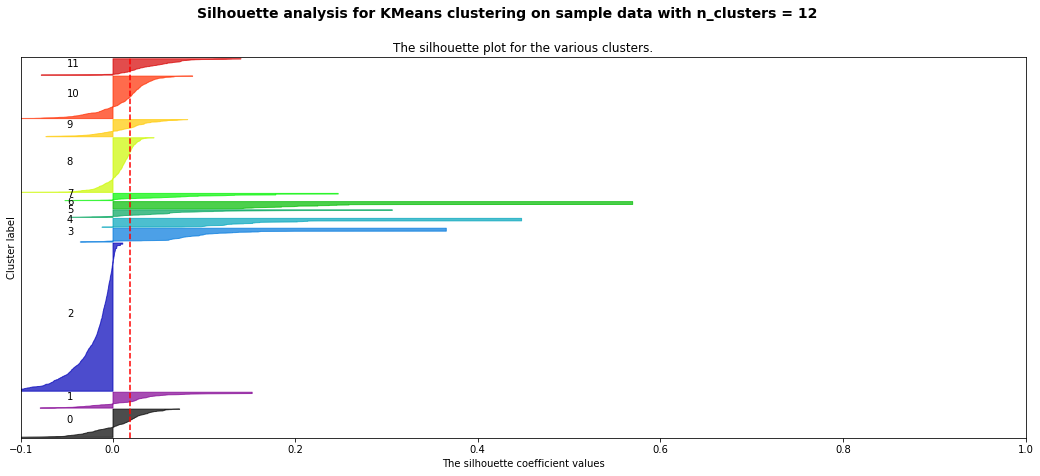

In [32]:
tcl.plot_silhouette()

Another way of visualizing the clusters is to plot the points and colorize according to their cluster.
Because the number of dimensions of the TFIDF matrix is extremely high, we can perform a PCA transform of the matrix and
keep a small number of coordinates. These coordinates carry only a small percentage of the total information, but enough
to illustrate a point.

In [61]:
import plotly.express as px
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5)
Y = svd.fit_transform(tcl.tfidf_matrix)
print(svd.explained_variance_ratio_)
fig = px.scatter_matrix(Y, color=tcl.clustered_data.pred)
fig.show()

fig2 = px.scatter(x=Y[:,0], y=Y[:,3], color=tcl.clustered_data.pred)
fig2.show()
fig3 = px.scatter(x=Y[:,2], y=Y[:,4], color=tcl.clustered_data.pred)
fig3.show()
fig4 = px.scatter(x=Y[:,4], y=Y[:,3], color=tcl.clustered_data.pred)
fig4.show()

[0.00875542 0.01749935 0.01596019 0.01208074 0.01127462]


As we can see, the cluster with the most points cannot be safely distinguished from others
since it carries the most generic information (reviews). This is also visible in the silhouette plot.

In [32]:
%load_ext autoreload
%autoreload 2

from util import import_data

def generate_dataset(size):
    data = import_data('datasets/clothing_5000.json', size=5000, file_type='json',
                       field='reviewText', label='clothing').sample(size).reset_index()
    data = data.append(import_data('datasets/books_5000.json', size=5000, file_type='json',
                                   field='reviewText', label='books').sample(
        size).reset_index())
    data = data.append(
        import_data('datasets/movies_5000.json', size=5000, file_type='json', field='reviewText',
                    label='movies').sample(
            size).reset_index())
    data = data.append(import_data('datasets/software_5000.json', size=5000, file_type='json', field='reviewText',
                                   label='software').sample(
        size).reset_index())
    data = data.append(
        import_data('datasets/music_5000.json', size=5000, file_type='json', field='reviewText',
                    label='music').sample(
            size).reset_index())
    data = data.reset_index()
    return data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 4 Classification with Naive Bayes <a name="classification"></a>

The purpose of this process is to train a classifier model, to assign user reviews to the output categories.
This would be useful for automated categorization of reviews, or identifying user preferences.
For text classification we consider using Naive Bayes or SVM as the classifiers.

## 4.1 Naive Bayes

Naive Bayes is based on the assumption that the features (dimensions) present in the input data, are independent of one another.
Given an input variable $f_i$, an observation $F$ and a class label $c_k$. The algorithm uses the Bayes therorem to calculate the probability:

$P(c_k|f_i=F) =  \frac{P(f_i=F|c_k)P(c_k)}{P(f_i=F)} = \frac{P(f_i=F|c_k)P(c_k)}{\sum_j{P(f_i=F|c_j)}P(c_j)} $

The variable $f_i$ can be discrete or continuous. In the latter case, during the training phase, the algorithm estimates the parameters of the probability density function:

$p(f_i|c_j)$

, for each class $c_j$ and assuming a gaussian or multinomial distribution. In the case of NLP the multinomial naive Bayes gives better results,
due to the bag of words model used for feature extraction. These features are better approximated by multinomial rather than gaussian distributions.


## 4.2 Initial attempt with 200 samples per class
We present the result of the Naive Bayes algorithm for a small number of samples. The metrics presented
are:

* Accuracy
* Precision
* Recall
* F1 score
* Confusion matrix

Accuracy is a generic measure that shows the total correct predictions versus the total predictions.
The rest of the metrics are calculated per class. Precision is an insight of how sensitive is the algorithm to misclassifying samples to the specific class, that
should belong to other classes. On the other hand, Recall shows the ability of the classifier to identify the samples that truly belong to the specific class.
F1 is a combination of the above


In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import plotly.express as px
import pandas as pd
from IPython.display import display

from models.classification import TextClassification
from sklearn.model_selection import train_test_split

data = generate_dataset(200)
X_train, X_test, y_train, y_test = train_test_split(data.input, data.label, test_size=0.2)
tcf = TextClassification()
tcf.train(X_train, y_train)

labels = ["books", "movies", "software", "clothing", "music"]

y_pred, pred_time = tcf.predict(X_test)
acc = tcf.accuracy_score(X_test, y_test)
pre, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, labels=labels)
metrics_exp_0 = pd.DataFrame({'Accuracy': [acc] * 5,
                        'Precision': pre,
                        'Recall': rec,
                        'F1': f1,
                        'Label': labels})
display(metrics_exp_0)

cm = confusion_matrix(y_test, y_pred, labels=["books", "movies", "software", "clothing", "music"])
df_cm = pd.DataFrame(cm, columns=["books", "movies", "software", "clothing", "music"], index=labels)
fig = px.imshow(df_cm, title="Confusion matrix for dataset with 200 samples per class (80/20 split).",
                labels={'x': 'predicted (y_pred)', 'y': 'actual (y_test)'})
fig.show()

Accuracy  Precision    Recall        F1     Label
0     0.845   0.872340  0.911111  0.891304     books
1     0.845   0.937500  0.697674  0.800000    movies
2     0.845   0.880000  0.956522  0.916667  software
3     0.845   0.692308  0.870968  0.771429  clothing
4     0.845   0.843750  0.771429  0.805970     music

Investigating the cases where the prediction doesn't match the real label, we can see that the input text in those cases is very generic, like
*Love it!*, *Item as described*

In [15]:
df_pred = pd.DataFrame({'pred': y_pred, 'actual': y_test}).join(data)
df_pred.loc[df_pred.pred != df_pred.label, ['pred', 'actual', 'input']]

pred    actual                                              input
582     books    movies  For the smart, beautiful unicorn I know is out...
424     books    movies           My kids were singing the songs for weeks
911    movies     music                                               good
104  software  clothing  Remain a classic, brings back memories, easy t...
508     books    movies                          old favorite and still is
832  software     music  One stopped working within 2 months of used an...
977  clothing     music  The mallet balls are a little harder than I ex...
995  software     music  It is portable, small and just what I need to ...
281  software     books                          yes, just what we needed!
905  clothing     music                                  Just as expected!
882  clothing     music       Like it very much, perfect fit & nice sound.
715     books  software  "Message in a Haunted Mansion" was my second N...
176     music  clothing                                        thumbs up:)
414     books    movies                                        Not for me.
6       books  clothing                                    too lage for me
901    movies     music              Bought as a gift, recipient loved it!
52   software  clothing                            for the money, good buy
642    movies  software  I have been playing Nancy Drew games for over ...
815    movies     music                                               good
855     books     music  Bought as toy for grandson for his music colle...
40   software  clothing  It will work for its intended purpose. Its kin...
120  software  clothing                                    Just a bit long
172  software  clothing  Very satisfied with item as well as the quick ...
955  clothing     music    Perfect for jamming on live or around the house
988  software     music            Works just like it should! No problems.
21      music  clothing                                      they cool tho
464     books    movies                        DID NOT THINK KIDS LIKED IT
10   software  clothing                                   run way too big.
462  software    movies                                                Bad
963  software     music  So it doesn't hold it's position, is really an...
852  software     music  Great product at Great Price Love the add on o...

## 4.3 Visualization of the classified points
In order to visualize the points, first we have to perform a dimensionality reduction using PCA.
We keep the 5 most important transformed dimensions and plot pairwise.

The colors of the points match their respective category only of the predicted label is equal to the true label.
If the point is misclassified it is denoted in red.

In [10]:
from util import TextPreprocessor
import pandas as pd
from sklearn.decomposition import TruncatedSVD

data = generate_dataset(200)
X_train, X_test, y_train, y_test = train_test_split(data.input, data.label, test_size=0.2)
tcf = TextClassification()
tcf.train(X_train, y_train)

svd = TruncatedSVD(n_components=5)
vb = tcf.tpr.vocabulary
tpr = TextPreprocessor(vocabulary=vb)

data = generate_dataset(1000)
X_prod, y_prod = data.input, data.label
y_pred_, pred_time = tcf.predict(X_prod)
print("Finished in {}", pred_time)
print("generating pca trasform and plot")

tfidf_vector, tfidf_matrix, _ = tpr.generate_tfidf(X_prod, debug=False, dense=False)
Y = svd.fit_transform(tfidf_matrix)
fig = px.scatter(x=Y[:,1], y=Y[:,3], color=[v if v == u else 'incorrect class' for v, u in zip(y_prod, y_pred_)])
fig.show()
fig3 = px.scatter(x=Y[:,2], y=Y[:,4], color=[v if v == u else 'incorrect class' for v, u in zip(y_prod, y_pred_)])
fig3.show()
fig4 = px.scatter(x=Y[:,4], y=Y[:,3], color=[v if v == u else 'incorrect class' for v, u in zip(y_prod, y_pred_)])
fig4.show()

Finished in {} 85.1560468673706
generating pca trasform and plot


## 4.4 Adjusting the sample size
We can increase the dataset used for training and examine how the different scores, as well as the training time, are affected.
For the precision, recall and F1 we will be taking the average of all classes.

In [11]:
import numpy as np

print("Running experiment with multiple training sample sizes. May take a while")
sample_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
acc, pre, rec, f1, sup = [], [], [], [], []
training_time = []
testing_time = []
feature_size = []

for size in sample_sizes:
    # Generate and split
    data = generate_dataset(size)
    X_train, X_test, y_train, y_test = train_test_split(data.input, data.label, test_size=0.2)

    # Train model
    tcf = TextClassification()
    feature_size_, training_time_ = tcf.train(X_train, y_train)

    # Calculate scores
    y_pred, testing_time_ = tcf.predict(X_test)
    pre_, rec_, f1_, sup_ = precision_recall_fscore_support(y_test, y_pred, labels=labels, average='weighted')

    acc.append(tcf.accuracy_score(X_test, y_test))
    pre.append(pre_)
    rec.append(rec_)
    f1.append(f1_)
    sup.append(sup_)
    feature_size.append(feature_size_)
    training_time.append(training_time_)
    testing_time.append(testing_time_)

metrics_exp_1 = pd.DataFrame({
    'samples per class': sample_sizes,
    'training_time': training_time,
    'testing_time': testing_time,
    'testing_time_per_sample': np.array(testing_time) / np.array(sample_sizes),
    'feature_size': feature_size,
    'accuracy': acc,
    'precision': pre,
    'recall': rec,
    'F1': f1})
print("Done")

Done


In [12]:
display(metrics_exp_1)

df_metrics = metrics_exp_1.melt(
    id_vars=['samples per class', 'training_time', 'testing_time', 'feature_size', 'testing_time_per_sample'],
    var_name='metric', value_name='score')

import plotly.express as px

fig = px.line(df_metrics, x='samples per class', y='score', color='metric', title='Performance metrics')
fig.show()

df_time = metrics_exp_1.loc[:, ['feature_size', 'training_time', 'testing_time_per_sample']].melt(id_vars=['feature_size'], var_name='metric', value_name='score')
fig2 = px.line(df_time, x='feature_size', y='score', color='metric', title='Training and Testing time')
fig2.show()

fig3 = px.histogram(df_metrics, x='testing_time_per_sample', title='Distribution of the testing times per sample')
fig3.show()


samples per class  training_time  testing_time  testing_time_per_sample  \
0                  50       4.029004      1.005032                 0.020101   
1                 100       7.857004      2.348038                 0.023480   
2                 200      14.322013      4.138989                 0.020695   
3                 300      22.532997      7.393111                 0.024644   
4                 400      29.310971      7.782029                 0.019455   
5                 500      40.801944     10.305041                 0.020610   
6                 600      50.183286     11.846969                 0.019745   
7                 700      55.791870     12.986999                 0.018553   
8                 800      58.013751     16.886000                 0.021107   
9                 900      64.274037     17.437995                 0.019376   
10               1000      75.035968     19.387996                 0.019388   

    feature_size  accuracy  precision    recall        F1  
0           2739  0.600000   0.702996  0.600000  0.611830  
1           4365  0.830000   0.847989  0.830000  0.833256  
2           6011  0.835000   0.841643  0.835000  0.835074  
3           7671  0.826667   0.832063  0.826667  0.827257  
4           8399  0.855000   0.864227  0.855000  0.854536  
5           9503  0.870000   0.872489  0.870000  0.869498  
6          10549  0.868333   0.873092  0.868333  0.867201  
7          11350  0.870000   0.872379  0.870000  0.870156  
8          11878  0.863750   0.865749  0.863750  0.863894  
9          12645  0.855556   0.860786  0.855556  0.854814  
10         13648  0.877000   0.880084  0.877000  0.877041

It is obvious that further increasing the training dataset's size past a specific point (around 200 samples per class), doesn't
increase the classifier's performance any further.

The training time complexity of naive bayes is O(n), while for TFIDF an efficient implementation performs the transformation in O(nlogn).
Therefore the total complexity is O(n) + O(nlogn), which can be verified from the diagram above.

The training time per sample remains relatively the same.

## 4.5 Shuffle & Split validation
We measure the algorithm's robustness by repeating the train-test process multiple times.
At each iteration the dataset's samples are shuffled and then split to train/test datasets, keeping the same ratio (0.2).

In [16]:
from sklearn.model_selection import ShuffleSplit

df = generate_dataset(200)
rs = ShuffleSplit(n_splits=40, train_size=200, test_size=100)

acc, pre, rec, f1, sup = [], [], [], [], []
for train_idx, test_idx in rs.split(df):
    df_train = df.loc[train_idx, :]
    df_test = df.loc[test_idx, :]

    X_train, X_test, y_train, y_test = df_train.input, df_test.input, df_train.label, df_test.label

    # Train model
    tcf = TextClassification()
    feature_size_, training_time_ = tcf.train(X_train, y_train)

    # Calculate scores
    y_pred, testing_time_ = tcf.predict(X_test)
    pre_, rec_, f1_, sup_ = precision_recall_fscore_support(y_test, y_pred, labels=labels, average='weighted')

    acc.append(tcf.accuracy_score(X_test, y_test))
    pre.append(pre_)
    rec.append(rec_)
    f1.append(f1_)
    sup.append(sup_)

metrics_exp_2 = pd.DataFrame({
    'accuracy': acc,
    'precision': pre,
    'recall': rec,
    'F1': f1})

print("Done")

Done


In [22]:
df_metrics_exp_2 = metrics_exp_2.melt(var_name="metric", value_name="score")
fig = px.histogram(df_metrics_exp_2, x='score', facet_col='metric', histnorm='probability density')
fig.show()

# 5 Conclusion

We have demonstrated the means to categorize and label text reviews using the most popular clustering and classification algorithms.
Please run the microservice included in the repo, which offers the above as a tool.